In [1]:
using Revise, Pkg
Pkg.activate("/home/louise/MSA/BpAlignGpu.jl")
using BpAlignGpu

  Activating project at `~/MSA/BpAlignGpu.jl`


In [2]:
using Plots, Statistics, DelimitedFiles

In [3]:
using CUDA
CUDA.device!(1)
CUDA.allowscalar(false)

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/louise/.julia/packages/CUDA/Uurn4/src/initialization.jl:70


In [4]:
T = Float32
q = 21
ctype=Symbol("amino")
typel=Symbol("bm");

In [5]:
muext = 0.00
muint = 2.50;

# -------------- Choose family --------------

In [6]:
#fam = "PF00684"
#open("/home/louise/MSA/Data/test/PF00684/")
#L = 67; 

#J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00684/Parameters_bm_PF00684seed_potts.dat", q, L, gap=0, typel=typel);

#delta = 50;
#al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00684/Test_PF00684.full", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.fasta", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.ins", delta = delta, ctype = ctype);
#M = length(al)

#Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00684/Lambda_PF00684.dat")
#lambda_o = Lambda_all[:,1];
#lambda_e = Lambda_all[:,2];


In [7]:
fam = "PF00397"
open("/home/louise/MSA/Data/test/PF00397/")
L = 31; 

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00397/Parameters_plm_PF00397.dat", q, L, gap=0, typel=typel);

delta = 5;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00397/PF00397_full_length_sequences.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.inse", delta = delta, ctype = ctype);
M = length(al)

Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00397/Lambda_PF00397.dat")
lambda_o = Lambda_all[1,:];
lambda_e = Lambda_all[2,:];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [8]:
##Random Data
#(N, L) = (6, 5) 
##(N, L) = (161, 67)

#lambda_o = ones(L)
#lambda_e = ones(L)
#H = rand(q,L)
#J = rand(q,q,L,L)
#J = J .+ permutedims(J, (2,1,4,3));

In [9]:
(Nmin, Nmax) = extrema([length(al[idx0][2]) for idx0 in 1:M])
ibig = findall([length(al[idx0][2]) for idx0 in 1:M] .== Nmax)[1]
ismall = findall([length(al[idx0][2]) for idx0 in 1:M] .== Nmin)[1];
(Nmin, Nmax, M)

(22, 52, 59696)

# -------------- one sequence, one epsilon --------------

In [ ]:
#idx0 = rand(1:M)
idx0=100

In [ ]:
seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
@show seq
N = length(al[idx0][2])

In [ ]:
pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)

In [ ]:
#build paramalgo
damp=T(0.5)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:sequential 
initcond=:random 
lr=:sce  
beta=T(0.0)
verbose=false

ϵ = -0.9
xnsol = fill((0, 0), L);
epscoupling=(false, T(ϵ), xnsol)
#epscoupling=(true, T(ϵ), xnsol_0)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

In [ ]:
bpm = BPMessages(seq, pm, pa)
bpb = BPBeliefs(N, L)
lrf = LongRangeFields(N, L)
af = AllFields(bpm, bpb, lrf)

In [ ]:
##find ground state
#iters = 1000
#minpol = 0.90
#nmax = 100
#minbet = 0.06
#@time beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, xnsol_ϵ, bel_ϵ = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet);

iters = 1000
betarange = 0.0:0.1:1.0
minpol = 0.7
@time beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, xnsol_ϵ, bel_ϵ = BpAlignGpu.findGS_betarange(af, pm, pa, seq; iters=iters, betarange = betarange, minpol = minpol);


In [ ]:
beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, exp(S_ϵ)

In [ ]:
P = fill(fill(0.0, 0:1,0:N+1), L)
#if check_ϵ > 0
#    println("need decimation, check=", check_ϵ)
    BpAlignGpu.reshape_T3(bel_ϵ,P);
    s, P = BpAlignGpu.decimate_post(seq, P, L, q, N, false);
    sol_decim = BpAlignGpu.decodeposterior(P, seq.strseq)
    
    energy_decim = BpAlignGpu.compute_cost_function(pm.J, pm.H, sol_decim[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)

    xn_decim = BpAlignGpu.convertseqtoxnsol(sol_decim, pm)
    c = BpAlignGpu.check_sr!(xn_decim, L, N)
    @show sum(c), energy_decim
    @show xnsol_ϵ == xn_decim

    sat = BpAlignGpu.check_assignment(P,true,N)
#end

In [ ]:
xnsol_vit, p_vit = BpAlignGpu.viterbi_decoding(af, pm)
@show xnsol_vit == xn_decim
c = BpAlignGpu.check_sr!(xnsol_vit, L, N)
@show sum(c)
seqsol_vit = BpAlignGpu.convert_soltosequence!(xnsol_vit, seq.strseq, N, L)
energy_vit = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_vit[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)


In [ ]:
sum(xnsol_vit .!= xn_decim), findall(xnsol_vit .!= xn_decim)

In [ ]:
energy_ϵ, energy_decim, energy_vit, U_ϵ, S_ϵ

In [ ]:
xnsol_0 = copy(xnsol_vit);
bel_0 = copy(bel_ϵ);

In [ ]:
t_vit = zeros(size(bel_ϵ[:,:,:]))
t_maxP = zeros(size(bel_ϵ[:,:,:]))
for i=1:L
    n,x = xnsol_vit[i]
    t_vit[x+1, n+1, i] = 1.0
    n,x = xnsol_ϵ[i]
    t_maxP[x+1, n+1, i] = 1.0
end

In [ ]:
p0 = heatmap(bel_ϵ[:,1,:], xlabel="i", ylabel="n", title="P_i:x=0")
p1 = heatmap(bel_ϵ[:,2,:], xlabel="i", ylabel="n", title="P_i:x=1")
p = plot(p0, p1, size=(800,400))

In [ ]:
p2 = heatmap(t_vit[:,1,:] .- t_maxP[:,1,:], xlabel="i", ylabel="n", title="diff Vit/max(P):x=0")
p3 = heatmap(t_vit[:,2,:] .- t_maxP[:,2,:], xlabel="i", ylabel="n", title="diff Vit/max(P):x=1")
plot(p2,p3, size=(800,400))

In [ ]:
p00 = heatmap(bel_ϵ[:,1,:] .- bel_0[:,1,:], xlabel="i", ylabel="n", title="Diff ϵ: x=0")
p01 = heatmap(bel_ϵ[:,2,:] .- bel_0[:,2,:], xlabel="i", ylabel="n", title="Diff ϵ: x=1")
p = plot(p00, p01, size=(800,400))

In [ ]:
#scatter(bel_0[:], bel_ϵ[:])

# -------------- Loop over sequences --------------

In [11]:
#nsamp=100
#samps = rand(1:M, nsamp);
samps = readdlm("indices_seedPF00397.txt");
samps = Int.(samps)[:,1]

374-element Vector{Int64}:
 58761
 44476
  2398
  9972
 30811
 46070
 16831
 31187
 16444
   939
 35755
 56335
 52084
     ⋮
 10729
 40873
 59283
 57632
 31024
  1199
 26759
 56328
 41708
   460
 41299
 43678

In [ ]:
#for (i,idx0) in pairs(samps)
#    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
#    N = length(al[idx0][2])
#    @show i, idx0, N
#end    

In [12]:
#build paramalgo
damp=T(0.9)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:sequential 
initcond=:random 
lr=:sce  
beta=T(0.0)
verbose=false
xnsol = fill((0, 0), L);
epscoupling=(false, T(0.0), xnsol)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

ParamAlgo{Float32}
-------------
damp=0.9
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=sequential
initcond=random
lr=sce
beta=0.0
verbose=false
epscoupling=false
-------------

In [14]:
nsamp = length(samps)

374

In [15]:
betas_seq = []
errs_seq = []
polars_seq = []

check_seq = []
ens_seq = []
ens_nucleation = []
ens_viterbi = []
U_seq = []
S_seq = []

xnsols_seq = fill((0, 0), L, nsamp)
xnsols_nucleation = fill((0, 0), L, nsamp)
xnsols_viterbi = fill((0, 0), L, nsamp)
#bels_seq = zeros(Nmax+2,2,L, nsamp);

In [ ]:
iters = 700
minpol = 0.90
nmax = 30
minbet = 0.01


for (i,idx0) in pairs(samps)
    @show i, idx0

    #build seq, pm
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    @show seq
    
    #build BP fields
    bpm = BPMessages(seq, pm, pa)
    bpb = BPBeliefs(N, L)
    lrf = LongRangeFields(N, L)
    af = AllFields(bpm, bpb, lrf)
    
    #find ground state
    pa.beta = 0.0
    @time beta, err, polar, energy, check, U, S, xnsol, bel = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet)    

    #decimation using nucleation
    P = fill(fill(0.0, 0:1,0:N+1), L)
    BpAlignGpu.reshape_T3(bel,P)
    s, P = BpAlignGpu.decimate_post(seq, P, L, q, N, false);
    seqsol_nucl = BpAlignGpu.decodeposterior(P, seq.strseq)
    sat = BpAlignGpu.check_assignment(P,false,N)
    if sat == false
        println("problem during nucleation")
        exit(0)
    end
    xnsol_nucl = BpAlignGpu.convertseqtoxnsol(seqsol_nucl, pm)
    energy_nucl = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_nucl[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    
    #decimation using Viterbi
    xnsol_vit, p_vit = BpAlignGpu.viterbi_decoding(af, pm)
    seqsol_vit = BpAlignGpu.convert_soltosequence!(xnsol_vit, seq.strseq, N, L)
    energy_vit = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_vit[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    c = BpAlignGpu.check_sr!(xnsol_vit, L, N)
    if sum(c) > 0
        println("problem during viterbi: new check=", sum(c))
        exit(0)
    end
    
    
    #store betas, convergence errors, energies and minimum polarizations
    append!(betas_seq, beta)
    append!(errs_seq, err)
    append!(polars_seq, polar)
    append!(ens_seq, energy)
    append!(check_seq, check)
    append!(U_seq, U)
    append!(S_seq, S)
    append!(ens_nucleation, energy_nucl)
    append!(ens_viterbi, energy_vit)
    
    #compute solution:
    xnsols_seq[:,i] = xnsol
    xnsols_nucleation[:,i] = xnsol_nucl
    xnsols_viterbi[:,i] = xnsol_vit
    #bels_seq[1:N+2,:,:,i] = bel
    
    println("\n")
end

(i, idx0) = (1, 58761)
seq = LPEHWKACRSEK-GELYYFNFKTGESIWDHP
GLKAPLPEHWKACRSEKGELYYFNFKTGESIWDHPLDEHF
beta = 0.0f0
converged: err=0.0009918585, tol=0.001, nbiter=58
(polar, energy, err) = (0.03870628f0, 30.031162f0, 0.0009918585f0)
beta = 0.1
converged: err=0.0009672642, tol=0.001, nbiter=41
(polar, energy, err) = (0.051239256f0, 52.810226f0, 0.0009672642f0)
beta = 0.2
converged: err=0.00097587705, tol=0.001, nbiter=45
(polar, energy, err) = (0.07171972f0, 25.333088f0, 0.00097587705f0)
beta = 0.30000000000000004
converged: err=0.0009965748, tol=0.001, nbiter=63
(polar, energy, err) = (0.11860922f0, -32.2864f0, 0.0009965748f0)
beta = 0.4
converged: err=0.0009986162, tol=0.001, nbiter=291
(polar, energy, err) = (0.74964494f0, -52.568497f0, 0.0009986162f0)
beta = 0.5
converged: err=0.000998199, tol=0.001, nbiter=101
(polar, energy, err) = (0.9080363f0, -52.568497f0, 0.000998199f0)
238.117460 seconds (270.19 M allocations: 13.907 GiB, 4.36% gc time, 55.57% compilation time)


(i, idx0) = (

converged: err=0.0009916276, tol=0.001, nbiter=104
(polar, energy, err) = (0.15357314f0, -38.98871f0, 0.0009916276f0)
beta = 0.4
converged: err=0.0009961426, tol=0.001, nbiter=216
(polar, energy, err) = (0.8542058f0, -55.646954f0, 0.0009961426f0)
beta = 0.5
converged: err=0.000986278, tol=0.001, nbiter=92
(polar, energy, err) = (0.9476259f0, -58.466206f0, 0.000986278f0)
 71.906069 seconds (34.15 M allocations: 1.777 GiB, 2.15% gc time, 16.57% compilation time)


(i, idx0) = (10, 939)
seq = LPDGWHAVIEVQTNDVYFWNIHTDETQWKVP
PFEDDLPDGWHAVIEVQTNDVYFWNIHTDETQWKVPTKPAS
beta = 0.0f0
converged: err=0.0009921044, tol=0.001, nbiter=54
(polar, energy, err) = (0.03730507f0, 38.23025f0, 0.0009921044f0)
beta = 0.1
converged: err=0.0009918362, tol=0.001, nbiter=40
(polar, energy, err) = (0.049751252f0, 46.263218f0, 0.0009918362f0)
beta = 0.2
converged: err=0.0009860694, tol=0.001, nbiter=44
(polar, energy, err) = (0.069763355f0, 20.498543f0, 0.0009860694f0)
beta = 0.30000000000000004
converged: err=0.

converged: err=0.0009903908, tol=0.001, nbiter=39
(polar, energy, err) = (0.049709294f0, 39.665794f0, 0.0009903908f0)
beta = 0.2
converged: err=0.0009677112, tol=0.001, nbiter=44
(polar, energy, err) = (0.06977466f0, 21.544754f0, 0.0009677112f0)
beta = 0.30000000000000004
converged: err=0.0009987503, tol=0.001, nbiter=81
(polar, energy, err) = (0.13398467f0, -31.02988f0, 0.0009987503f0)
beta = 0.4
converged: err=0.0009962916, tol=0.001, nbiter=196
(polar, energy, err) = (0.81489944f0, -59.801823f0, 0.0009962916f0)
beta = 0.5
converged: err=0.0009915233, tol=0.001, nbiter=72
(polar, energy, err) = (0.941625f0, -59.801823f0, 0.0009915233f0)
 54.925912 seconds (27.13 M allocations: 1.387 GiB, 2.72% gc time)


(i, idx0) = (19, 51460)
seq = LPENWEEAIDKSTGHKYYYNTKTQTTQWEPP
QVSPSLPENWEEAIDKSTGHKYYYNTKTQTTQWEPPSVSTS
beta = 0.0f0
converged: err=0.0009969547, tol=0.001, nbiter=57
(polar, energy, err) = (0.037777647f0, 40.990196f0, 0.0009969547f0)
beta = 0.1
converged: err=0.0009895563, tol=0.001

converged: err=0.0009911656, tol=0.001, nbiter=92
(polar, energy, err) = (0.94739383f0, -65.6446f0, 0.0009911656f0)
 61.126237 seconds (31.51 M allocations: 1.614 GiB, 2.62% gc time)


(i, idx0) = (27, 39035)
seq = LPENWELAFSDT-GEPYYINHNSKTTSWLDP
ARGGALPENWELAFSDTGEPYYINHNSKTTSWLDPRTQGK
beta = 0.0f0
converged: err=0.0009952039, tol=0.001, nbiter=56
(polar, energy, err) = (0.038584307f0, 41.88533f0, 0.0009952039f0)
beta = 0.1
converged: err=0.0009849817, tol=0.001, nbiter=39
(polar, energy, err) = (0.050482657f0, 42.65923f0, 0.0009849817f0)
beta = 0.2
converged: err=0.0009790361, tol=0.001, nbiter=45
(polar, energy, err) = (0.071484484f0, 18.446898f0, 0.0009790361f0)
beta = 0.30000000000000004
converged: err=0.0009814501, tol=0.001, nbiter=44
(polar, energy, err) = (0.10955881f0, -19.900166f0, 0.0009814501f0)
beta = 0.4
converged: err=0.0009950995, tol=0.001, nbiter=252
(polar, energy, err) = (0.80328065f0, -56.717247f0, 0.0009950995f0)
beta = 0.5
converged: err=0.0009961724, tol=0.001,

converged: err=0.0009957552, tol=0.001, nbiter=171
(polar, energy, err) = (0.83855873f0, -59.136227f0, 0.0009957552f0)
beta = 0.5
converged: err=0.0009767115, tol=0.001, nbiter=92
(polar, energy, err) = (0.9328071f0, -62.666718f0, 0.0009767115f0)
 65.603149 seconds (32.42 M allocations: 1.660 GiB, 3.05% gc time)


(i, idx0) = (36, 56062)
seq = LPTPWQQHMDPSSGKPYYYNPETSVTQWERP
TTDNELPTPWQQHMDPSSGKPYYYNPETSVTQWERPVVVAP
beta = 0.0f0
converged: err=0.0009924322, tol=0.001, nbiter=58
(polar, energy, err) = (0.03810137f0, 41.058815f0, 0.0009924322f0)
beta = 0.1
converged: err=0.0009983331, tol=0.001, nbiter=39
(polar, energy, err) = (0.050157946f0, 37.83193f0, 0.0009983331f0)
beta = 0.2
converged: err=0.00097104907, tol=0.001, nbiter=45
(polar, energy, err) = (0.07136843f0, 5.303765f0, 0.00097104907f0)
beta = 0.30000000000000004
converged: err=0.0009991229, tol=0.001, nbiter=182
(polar, energy, err) = (0.22643092f0, -46.866196f0, 0.0009991229f0)
beta = 0.4
converged: err=0.0009896159, tol=0.0

converged: err=0.00097581744, tol=0.001, nbiter=42
(polar, energy, err) = (0.10642335f0, -30.718369f0, 0.00097581744f0)
beta = 0.4
converged: err=0.0009884834, tol=0.001, nbiter=249
(polar, energy, err) = (0.83443f0, -57.930527f0, 0.0009884834f0)
beta = 0.5
converged: err=0.0009468198, tol=0.001, nbiter=148
(polar, energy, err) = (0.9602705f0, -57.930527f0, 0.0009468198f0)
 63.829017 seconds (32.10 M allocations: 1.641 GiB, 3.16% gc time)


(i, idx0) = (45, 41593)
seq = --SSWYEVKTSK-NYKYYYNKETKETKWERP
WNQLEESSWYEVKTSKNYKYYYNKETKETKWERPSLKNE
beta = 0.0f0
converged: err=0.0009918734, tol=0.001, nbiter=58
(polar, energy, err) = (0.03949167f0, 36.011696f0, 0.0009918734f0)
beta = 0.1
converged: err=0.0009838641, tol=0.001, nbiter=41
(polar, energy, err) = (0.05230856f0, 25.249268f0, 0.0009838641f0)
beta = 0.2
converged: err=0.0009931624, tol=0.001, nbiter=45
(polar, energy, err) = (0.07450833f0, -13.048862f0, 0.0009931624f0)
beta = 0.30000000000000004
converged: err=0.0009851903, tol=0.001,

converged: err=0.00094753504, tol=0.001, nbiter=94
(polar, energy, err) = (0.9633749f0, -64.16333f0, 0.00094753504f0)
 56.002953 seconds (32.25 M allocations: 1.649 GiB, 2.35% gc time)


(i, idx0) = (53, 16670)
seq = LPEPLEEHLDSSSGFSYYHNPMTNVTQWENP
AASLMLPEPLEEHLDSSSGFSYYHNPMTNVTQWENPLRDDA
beta = 0.0f0
converged: err=0.0009918436, tol=0.001, nbiter=56
(polar, energy, err) = (0.037572376f0, 30.557247f0, 0.0009918436f0)
beta = 0.1
converged: err=0.0009899884, tol=0.001, nbiter=39
(polar, energy, err) = (0.04969682f0, 51.250004f0, 0.0009899884f0)
beta = 0.2
converged: err=0.0009741485, tol=0.001, nbiter=44
(polar, energy, err) = (0.069808654f0, 24.878994f0, 0.0009741485f0)
beta = 0.30000000000000004
converged: err=0.0009956956, tol=0.001, nbiter=44
(polar, energy, err) = (0.10815921f0, -31.186714f0, 0.0009956956f0)
beta = 0.4
converged: err=0.0009964406, tol=0.001, nbiter=264
(polar, energy, err) = (0.7226386f0, -49.117138f0, 0.0009964406f0)
beta = 0.5
converged: err=0.0009886622, tol=0.0

converged: err=0.000982672, tol=0.001, nbiter=45
(polar, energy, err) = (0.07124648f0, 19.242275f0, 0.000982672f0)
beta = 0.30000000000000004
converged: err=0.0009938776, tol=0.001, nbiter=43
(polar, energy, err) = (0.10908183f0, -28.874504f0, 0.0009938776f0)
beta = 0.4
converged: err=0.000998199, tol=0.001, nbiter=192
(polar, energy, err) = (0.8397002f0, -60.568317f0, 0.000998199f0)
beta = 0.5
converged: err=0.0009852052, tol=0.001, nbiter=125
(polar, energy, err) = (0.9479766f0, -60.568317f0, 0.0009852052f0)
 53.938493 seconds (27.67 M allocations: 1.414 GiB, 2.93% gc time)


(i, idx0) = (62, 33746)
seq = LPPGWEEKQDER-GRSYYVDHNSRTTTWTKP
PTSSGLPPGWEEKQDERGRSYYVDHNSRTTTWTKPTVQAT
beta = 0.0f0
converged: err=0.0009944662, tol=0.001, nbiter=61
(polar, energy, err) = (0.03923762f0, 33.952137f0, 0.0009944662f0)
beta = 0.1
converged: err=0.00097166, tol=0.001, nbiter=40
(polar, energy, err) = (0.05176374f0, 37.242424f0, 0.00097166f0)
beta = 0.2
converged: err=0.0009700954, tol=0.001, nbiter=

converged: err=0.0009987205, tol=0.001, nbiter=52
(polar, energy, err) = (0.037690345f0, 34.998516f0, 0.0009987205f0)
beta = 0.1
converged: err=0.000995174, tol=0.001, nbiter=40
(polar, energy, err) = (0.050145227f0, 38.570835f0, 0.000995174f0)
beta = 0.2
converged: err=0.0009950697, tol=0.001, nbiter=44
(polar, energy, err) = (0.07104241f0, 21.079224f0, 0.0009950697f0)
beta = 0.30000000000000004
converged: err=0.0009713173, tol=0.001, nbiter=43
(polar, energy, err) = (0.10891499f0, -35.627285f0, 0.0009713173f0)
beta = 0.4
converged: err=0.000992775, tol=0.001, nbiter=247
(polar, energy, err) = (0.81040144f0, -53.915604f0, 0.000992775f0)
beta = 0.5
converged: err=0.0009788275, tol=0.001, nbiter=73
(polar, energy, err) = (0.94062686f0, -55.735123f0, 0.0009788275f0)
 53.407242 seconds (27.66 M allocations: 1.415 GiB, 2.32% gc time)


(i, idx0) = (71, 6273)
seq = LPAGWEIRSTTD-GRRYFVDHNTRSTTFRDP
VETMPLPAGWEIRSTTDGRRYFVDHNTRSTTFRDPRLDLA
beta = 0.0f0
converged: err=0.0009913743, tol=0.001, n

converged: err=0.0009960532, tol=0.001, nbiter=211
(polar, energy, err) = (0.8300476f0, -58.724934f0, 0.0009960532f0)
beta = 0.5
converged: err=0.0009605363, tol=0.001, nbiter=103
(polar, energy, err) = (0.9446915f0, -58.724934f0, 0.0009605363f0)
 54.546490 seconds (27.60 M allocations: 1.414 GiB, 2.49% gc time)


(i, idx0) = (79, 49010)
seq = LPEGWIAQWDDEYNHYFFVNTVTGESQWEIP
PRLPQLPEGWIAQWDDEYNHYFFVNTVTGESQWEIPESSVP
beta = 0.0f0
converged: err=0.0009937957, tol=0.001, nbiter=56
(polar, energy, err) = (0.037610687f0, 52.715466f0, 0.0009937957f0)
beta = 0.1
converged: err=0.0009765923, tol=0.001, nbiter=40
(polar, energy, err) = (0.050032977f0, 52.09201f0, 0.0009765923f0)
beta = 0.2
converged: err=0.0009860098, tol=0.001, nbiter=44
(polar, energy, err) = (0.07022312f0, 17.31963f0, 0.0009860098f0)
beta = 0.30000000000000004
converged: err=0.0009953007, tol=0.001, nbiter=70
(polar, energy, err) = (0.12752444f0, -34.97577f0, 0.0009953007f0)
beta = 0.4
converged: err=0.0009896159, tol=0.001,

converged: err=0.0009970963, tol=0.001, nbiter=41
(polar, energy, err) = (0.05184279f0, 28.942661f0, 0.0009970963f0)
beta = 0.2
converged: err=0.0009931326, tol=0.001, nbiter=44
(polar, energy, err) = (0.07357476f0, 5.351855f0, 0.0009931326f0)
beta = 0.30000000000000004
converged: err=0.0009847879, tol=0.001, nbiter=41
(polar, energy, err) = (0.113847286f0, -33.826614f0, 0.0009847879f0)
beta = 0.4
converged: err=0.0009922385, tol=0.001, nbiter=204
(polar, energy, err) = (0.8227829f0, -60.003166f0, 0.0009922385f0)
beta = 0.5
converged: err=0.00096052885, tol=0.001, nbiter=114
(polar, energy, err) = (0.9496597f0, -60.003166f0, 0.00096052885f0)
 54.880250 seconds (27.84 M allocations: 1.427 GiB, 2.49% gc time)


(i, idx0) = (88, 10364)
seq = -PPGWSEHVDGS-GREFYHHAATGRSSYEHP
ALLAPPPPGWSEHVDGSGREFYHHAATGRSSYEHPMDDTY
beta = 0.0f0
converged: err=0.0009951219, tol=0.001, nbiter=54
(polar, energy, err) = (0.03802432f0, 34.395866f0, 0.0009951219f0)
beta = 0.1
converged: err=0.00096803904, tol=0.0

converged: err=0.0009909272, tol=0.001, nbiter=227
(polar, energy, err) = (0.8054321f0, -55.702564f0, 0.0009909272f0)
beta = 0.5
converged: err=0.0009742975, tol=0.001, nbiter=141
(polar, energy, err) = (0.91368926f0, -55.702564f0, 0.0009742975f0)
 59.907411 seconds (31.59 M allocations: 1.617 GiB, 2.77% gc time)


(i, idx0) = (96, 33194)
seq = ---PWRALDDGK-GNVYYYNALTGVSQWEKP
APVAAANPWRALDDGKGNVYYYNALTGVSQWEKPSELT
beta = 0.0f0
converged: err=0.0009891689, tol=0.001, nbiter=59
(polar, energy, err) = (0.04073535f0, 34.11664f0, 0.0009891689f0)
beta = 0.1
converged: err=0.0009899288, tol=0.001, nbiter=42
(polar, energy, err) = (0.05367813f0, 39.782444f0, 0.0009899288f0)
beta = 0.2
converged: err=0.000991106, tol=0.001, nbiter=45
(polar, energy, err) = (0.07557239f0, 15.166449f0, 0.000991106f0)
beta = 0.30000000000000004
converged: err=0.0009867251, tol=0.001, nbiter=156
(polar, energy, err) = (0.20442665f0, -41.465923f0, 0.0009867251f0)
beta = 0.4
converged: err=0.0009869933, tol=0.001, nb

converged: err=0.0009915829, tol=0.001, nbiter=39
(polar, energy, err) = (0.051348668f0, 30.81179f0, 0.0009915829f0)
beta = 0.2
converged: err=0.00097587705, tol=0.001, nbiter=44
(polar, energy, err) = (0.07348985f0, 3.4447346f0, 0.00097587705f0)
beta = 0.30000000000000004
converged: err=0.0009921938, tol=0.001, nbiter=165
(polar, energy, err) = (0.19822758f0, -38.67475f0, 0.0009921938f0)
beta = 0.4
converged: err=0.0009904504, tol=0.001, nbiter=173
(polar, energy, err) = (0.8489421f0, -64.35674f0, 0.0009904504f0)
beta = 0.5
converged: err=0.0009909868, tol=0.001, nbiter=104
(polar, energy, err) = (0.9398993f0, -64.35674f0, 0.0009909868f0)
 62.721673 seconds (32.39 M allocations: 1.657 GiB, 3.08% gc time)


(i, idx0) = (105, 57898)
seq = -TSPWRSATAAD-GQVYYYNQNTGETQWDKP
PMPPALTSPWRSATAADGQVYYYNQNTGETQWDKPPGL
beta = 0.0f0
converged: err=0.0009929016, tol=0.001, nbiter=63
(polar, energy, err) = (0.04129738f0, 31.370716f0, 0.0009929016f0)
beta = 0.1
converged: err=0.0009950399, tol=0.001, 

converged: err=0.0009923279, tol=0.001, nbiter=57
(polar, energy, err) = (0.03863705f0, 32.174496f0, 0.0009923279f0)
beta = 0.1
converged: err=0.0009901226, tol=0.001, nbiter=40
(polar, energy, err) = (0.051011853f0, 49.255215f0, 0.0009901226f0)
beta = 0.2
converged: err=0.0009956658, tol=0.001, nbiter=45
(polar, energy, err) = (0.07205461f0, 19.035965f0, 0.0009956658f0)
beta = 0.30000000000000004
converged: err=0.0009988695, tol=0.001, nbiter=153
(polar, energy, err) = (0.1784653f0, -43.246723f0, 0.0009988695f0)
beta = 0.4
converged: err=0.0009868741, tol=0.001, nbiter=172
(polar, energy, err) = (0.8861652f0, -61.854935f0, 0.0009868741f0)
beta = 0.5
converged: err=0.0009807646, tol=0.001, nbiter=79
(polar, energy, err) = (0.95030427f0, -63.652214f0, 0.0009807646f0)
 58.472599 seconds (30.28 M allocations: 1.549 GiB, 2.73% gc time)


(i, idx0) = (114, 13267)
seq = ---AWNEFNAPD-GRKYYFNSITQENTWEKP
IPQNPDDAWNEFNAPDGRKYYFNSITQENTWEKPKALID
beta = 0.0f0
converged: err=0.0009915084, tol=0.001

converged: err=0.0009899139, tol=0.001, nbiter=228
(polar, energy, err) = (0.85177493f0, -59.9245f0, 0.0009899139f0)
beta = 0.5
converged: err=0.0009934306, tol=0.001, nbiter=91
(polar, energy, err) = (0.94844234f0, -59.9245f0, 0.0009934306f0)
 62.664724 seconds (31.60 M allocations: 1.617 GiB, 4.52% gc time)


(i, idx0) = (122, 19819)
seq = LPPGWEMRHNPN-GRIYFIDHNTRRTQAI--
GNLGELPPGWEMRHNPNGRIYFIDHNTRRTQAIDPRIAIK
beta = 0.0f0
converged: err=0.000996612, tol=0.001, nbiter=58
(polar, energy, err) = (0.03858642f0, 39.588943f0, 0.000996612f0)
beta = 0.1
converged: err=0.0009804964, tol=0.001, nbiter=40
(polar, energy, err) = (0.05103961f0, 33.082443f0, 0.0009804964f0)
beta = 0.2
converged: err=0.0009773076, tol=0.001, nbiter=44
(polar, energy, err) = (0.072307214f0, 16.357685f0, 0.0009773076f0)
beta = 0.30000000000000004
converged: err=0.0009992868, tol=0.001, nbiter=125
(polar, energy, err) = (0.16313334f0, -37.70795f0, 0.0009992868f0)
beta = 0.4
converged: err=0.0009889603, tol=0.001, nb

converged: err=0.0009966716, tol=0.001, nbiter=55
(polar, energy, err) = (0.038278487f0, 42.832996f0, 0.0009966716f0)
beta = 0.1
converged: err=0.0009787977, tol=0.001, nbiter=40
(polar, energy, err) = (0.050621238f0, 35.194153f0, 0.0009787977f0)
beta = 0.2
converged: err=0.0009711683, tol=0.001, nbiter=44
(polar, energy, err) = (0.07128079f0, 24.342583f0, 0.0009711683f0)
beta = 0.30000000000000004
converged: err=0.0009983778, tol=0.001, nbiter=44
(polar, energy, err) = (0.10750157f0, -22.970968f0, 0.0009983778f0)
beta = 0.4
converged: err=0.0009980798, tol=0.001, nbiter=297
(polar, energy, err) = (0.73752904f0, -52.142086f0, 0.0009980798f0)
beta = 0.5
converged: err=0.00072824955, tol=0.001, nbiter=210
(polar, energy, err) = (0.9265351f0, -52.142086f0, 0.00072824955f0)
 76.189025 seconds (38.26 M allocations: 1.957 GiB, 2.41% gc time)


(i, idx0) = (131, 7019)
seq = LPTPWIEYCDETTGKHYFYDSSTRHVRWHPP
TTVQPLPTPWIEYCDETTGKHYFYDSSTRHVRWHPPPATDA
beta = 0.0f0
converged: err=0.0009949878, tol=

converged: err=0.0009947419, tol=0.001, nbiter=230
(polar, energy, err) = (0.80971366f0, -53.430088f0, 0.0009947419f0)
beta = 0.5
converged: err=0.0009937882, tol=0.001, nbiter=96
(polar, energy, err) = (0.9317711f0, -56.14137f0, 0.0009937882f0)
 56.212050 seconds (32.06 M allocations: 1.639 GiB, 2.58% gc time)


(i, idx0) = (139, 50269)
seq = LPPGWVEAKDPATGVSYYYNESIGKSQWERP
VEVGKLPPGWVEAKDPATGVSYYYNESIGKSQWERPIESSL
beta = 0.0f0
converged: err=0.0009911731, tol=0.001, nbiter=57
(polar, energy, err) = (0.03771338f0, 32.59515f0, 0.0009911731f0)
beta = 0.1
converged: err=0.0009674728, tol=0.001, nbiter=40
(polar, energy, err) = (0.04994697f0, 31.517876f0, 0.0009674728f0)
beta = 0.2
converged: err=0.0009880364, tol=0.001, nbiter=43
(polar, energy, err) = (0.07009043f0, 10.663329f0, 0.0009880364f0)
beta = 0.30000000000000004
converged: err=0.0009801984, tol=0.001, nbiter=42
(polar, energy, err) = (0.108599946f0, -28.903961f0, 0.0009801984f0)
beta = 0.4
converged: err=0.0009880662, tol=0.001

converged: err=0.00097087026, tol=0.001, nbiter=45
(polar, energy, err) = (0.06966635f0, 29.4934f0, 0.00097087026f0)
beta = 0.30000000000000004
converged: err=0.0009808391, tol=0.001, nbiter=39
(polar, energy, err) = (0.10614318f0, -27.773151f0, 0.0009808391f0)
beta = 0.4
converged: err=0.000997901, tol=0.001, nbiter=227
(polar, energy, err) = (0.795686f0, -54.668343f0, 0.000997901f0)
beta = 0.5
converged: err=0.0009914637, tol=0.001, nbiter=64
(polar, energy, err) = (0.8997293f0, -54.668343f0, 0.0009914637f0)
beta = 0.6
converged: err=0.000988841, tol=0.001, nbiter=83
(polar, energy, err) = (0.9362642f0, -54.668343f0, 0.000988841f0)
 62.136362 seconds (30.63 M allocations: 1.568 GiB, 2.66% gc time)


(i, idx0) = (148, 40217)
seq = LPPGWSIG--QDYGEWYFIDHNTQTTSWIDP
YNAAMLPPGWSIGQDYGEWYFIDHNTQTTSWIDPRPLEQ
beta = 0.0f0
converged: err=0.0009910241, tol=0.001, nbiter=62
(polar, energy, err) = (0.040299416f0, 36.77428f0, 0.0009910241f0)
beta = 0.1
converged: err=0.0009900033, tol=0.001, nbite

converged: err=0.0009941161, tol=0.001, nbiter=40
(polar, energy, err) = (0.052386645f0, 46.30173f0, 0.0009941161f0)
beta = 0.2
converged: err=0.0009993613, tol=0.001, nbiter=45
(polar, energy, err) = (0.07398633f0, 7.0057583f0, 0.0009993613f0)
beta = 0.30000000000000004
converged: err=0.0009973347, tol=0.001, nbiter=114
(polar, energy, err) = (0.16208984f0, -35.09695f0, 0.0009973347f0)
beta = 0.4
converged: err=0.000993669, tol=0.001, nbiter=198
(polar, energy, err) = (0.81787807f0, -56.072643f0, 0.000993669f0)
beta = 0.5
converged: err=0.0009702444, tol=0.001, nbiter=86
(polar, energy, err) = (0.927018f0, -58.579067f0, 0.0009702444f0)
 55.973375 seconds (30.09 M allocations: 1.541 GiB, 1.88% gc time)


(i, idx0) = (156, 1502)
seq = LPSGWVALQDPTSGRTYYANQTTGESSWEMP
PVTPSLPSGWVALQDPTSGRTYYANQTTGESSWEMPQSQPA
beta = 0.0f0
converged: err=0.0009981021, tol=0.001, nbiter=57
(polar, energy, err) = (0.037761383f0, 38.353996f0, 0.0009981021f0)
beta = 0.1
converged: err=0.0009953678, tol=0.001, 

converged: err=0.00096803904, tol=0.001, nbiter=165
(polar, energy, err) = (0.93154067f0, -53.96928f0, 0.00096803904f0)
 79.057475 seconds (41.47 M allocations: 2.121 GiB, 2.56% gc time)


(i, idx0) = (164, 26840)
seq = --DGWRCHVDPTAQAYYFTNIRTGVSQWENP
PPDETDDGWRCHVDPTAQAYYFTNIRTGVSQWENPRVPEA
beta = 0.0f0
converged: err=0.0009934977, tol=0.001, nbiter=61
(polar, energy, err) = (0.039258406f0, 31.443474f0, 0.0009934977f0)
beta = 0.1
converged: err=0.0009926707, tol=0.001, nbiter=41
(polar, energy, err) = (0.051765252f0, 36.941513f0, 0.0009926707f0)
beta = 0.2
converged: err=0.0009755194, tol=0.001, nbiter=46
(polar, energy, err) = (0.07264799f0, 6.0732393f0, 0.0009755194f0)
beta = 0.30000000000000004
converged: err=0.0009976253, tol=0.001, nbiter=91
(polar, energy, err) = (0.14089592f0, -34.60528f0, 0.0009976253f0)
beta = 0.4
converged: err=0.0009911954, tol=0.001, nbiter=189
(polar, energy, err) = (0.82334286f0, -55.458035f0, 0.0009911954f0)
beta = 0.5
converged: err=0.0009859204, tol=0

converged: err=0.0009685457, tol=0.001, nbiter=47
(polar, energy, err) = (0.07292015f0, 19.669601f0, 0.0009685457f0)
beta = 0.30000000000000004
converged: err=0.0009815991, tol=0.001, nbiter=45
(polar, energy, err) = (0.113817975f0, -27.086311f0, 0.0009815991f0)
beta = 0.4
converged: err=0.0009990335, tol=0.001, nbiter=264
(polar, energy, err) = (0.80387646f0, -56.144104f0, 0.0009990335f0)
beta = 0.5
converged: err=0.0009895563, tol=0.001, nbiter=94
(polar, energy, err) = (0.93924457f0, -56.144104f0, 0.0009895563f0)
 59.004596 seconds (30.47 M allocations: 1.557 GiB, 2.15% gc time)


(i, idx0) = (173, 26625)
seq = -PVLWQEARNSD-GRVYYYNVQTKATQWTKP
NGMPVPPVLWQEARNSDGRVYYYNVQTKATQWTKPLELMT
beta = 0.0f0
converged: err=0.0009922385, tol=0.001, nbiter=62
(polar, energy, err) = (0.039460268f0, 34.95687f0, 0.0009922385f0)
beta = 0.1
converged: err=0.0009857565, tol=0.001, nbiter=40
(polar, energy, err) = (0.0518099f0, 17.058971f0, 0.0009857565f0)
beta = 0.2
converged: err=0.0009900033, tol=0.00

converged: err=0.0009896383, tol=0.001, nbiter=56
(polar, energy, err) = (0.03767509f0, 46.490047f0, 0.0009896383f0)
beta = 0.1
converged: err=0.000993371, tol=0.001, nbiter=40
(polar, energy, err) = (0.04993805f0, 47.55984f0, 0.000993371f0)
beta = 0.2
converged: err=0.0009846985, tol=0.001, nbiter=45
(polar, energy, err) = (0.07095609f0, 9.585534f0, 0.0009846985f0)
beta = 0.30000000000000004
converged: err=0.0009974465, tol=0.001, nbiter=59
(polar, energy, err) = (0.12097456f0, -36.66833f0, 0.0009974465f0)
beta = 0.4
converged: err=0.0009948611, tol=0.001, nbiter=197
(polar, energy, err) = (0.8618706f0, -61.340088f0, 0.0009948611f0)
beta = 0.5
converged: err=0.0009889603, tol=0.001, nbiter=90
(polar, energy, err) = (0.9601883f0, -61.340088f0, 0.0009889603f0)
 51.798553 seconds (26.98 M allocations: 1.381 GiB, 1.80% gc time)


(i, idx0) = (182, 44358)
seq = -PCAWKSSQTED-GKTYYYNKDTRETSWTPP
GEAEAGPCAWKSSQTEDGKTYYYNKDTRETSWTPPDDLSK
beta = 0.0f0
converged: err=0.000991337, tol=0.001, nbite

converged: err=0.0009782314, tol=0.001, nbiter=40
(polar, energy, err) = (0.10831778f0, -19.005306f0, 0.0009782314f0)
beta = 0.4
converged: err=0.0009867549, tol=0.001, nbiter=266
(polar, energy, err) = (0.803331f0, -56.737793f0, 0.0009867549f0)
beta = 0.5
converged: err=0.0009763837, tol=0.001, nbiter=120
(polar, energy, err) = (0.9355395f0, -56.737793f0, 0.0009763837f0)
 60.440720 seconds (31.63 M allocations: 1.615 GiB, 2.05% gc time)


(i, idx0) = (190, 39160)
seq = LPMNWTSAYDAGSGKYYYYHKVTQQSSWDRP
DMNYGLPMNWTSAYDAGSGKYYYYHKVTQQSSWDRPPGSLP
beta = 0.0f0
converged: err=0.0009967461, tol=0.001, nbiter=56
(polar, energy, err) = (0.037581246f0, 41.340385f0, 0.0009967461f0)
beta = 0.1
converged: err=0.0009845644, tol=0.001, nbiter=40
(polar, energy, err) = (0.049831856f0, 29.1661f0, 0.0009845644f0)
beta = 0.2
converged: err=0.0009862185, tol=0.001, nbiter=44
(polar, energy, err) = (0.07059013f0, 15.462439f0, 0.0009862185f0)
beta = 0.30000000000000004
converged: err=0.000994578, tol=0.001,

converged: err=0.0009986609, tol=0.001, nbiter=57
(polar, energy, err) = (0.038701113f0, 38.656075f0, 0.0009986609f0)
beta = 0.1
converged: err=0.0009786338, tol=0.001, nbiter=41
(polar, energy, err) = (0.051328596f0, 32.881805f0, 0.0009786338f0)
beta = 0.2
converged: err=0.0009838343, tol=0.001, nbiter=44
(polar, energy, err) = (0.07247497f0, 12.887214f0, 0.0009838343f0)
beta = 0.30000000000000004
converged: err=0.0009960085, tol=0.001, nbiter=173
(polar, energy, err) = (0.19760416f0, -38.777878f0, 0.0009960085f0)
beta = 0.4
converged: err=0.000988543, tol=0.001, nbiter=158
(polar, energy, err) = (0.83225214f0, -62.89023f0, 0.000988543f0)
beta = 0.5
converged: err=0.0009771585, tol=0.001, nbiter=157
(polar, energy, err) = (0.9401644f0, -62.89023f0, 0.0009771585f0)
 68.009571 seconds (34.89 M allocations: 1.786 GiB, 2.59% gc time)


(i, idx0) = (199, 27176)
seq = --APWQRAVSTSNQLPYYINHETEVTQWDHP
FLRDSVQAPWQRAVSTSNQLPYYINHETEVTQWDHPAMVEI
beta = 0.0f0
converged: err=0.0009935647, tol=0.00

converged: err=0.0009700656, tol=0.001, nbiter=45
(polar, energy, err) = (0.06926781f0, 24.287365f0, 0.0009700656f0)
beta = 0.30000000000000004
converged: err=0.0009929463, tol=0.001, nbiter=49
(polar, energy, err) = (0.10928838f0, -35.7151f0, 0.0009929463f0)
beta = 0.4
converged: err=0.0009941459, tol=0.001, nbiter=189
(polar, energy, err) = (0.89219856f0, -63.31262f0, 0.0009941459f0)
beta = 0.5
converged: err=0.0008652806, tol=0.001, nbiter=138
(polar, energy, err) = (0.97335714f0, -63.31262f0, 0.0008652806f0)
 56.418217 seconds (28.45 M allocations: 1.455 GiB, 2.73% gc time)


(i, idx0) = (207, 43860)
seq = LPLGWEELEDAS-GGKYYIDHNTETQQTEDP
CVGNELPLGWEELEDASGGKYYIDHNTETQQTEDPRIQWR
beta = 0.0f0
converged: err=0.0009991601, tol=0.001, nbiter=57
(polar, energy, err) = (0.038415257f0, 33.053764f0, 0.0009991601f0)
beta = 0.1
converged: err=0.0009956211, tol=0.001, nbiter=40
(polar, energy, err) = (0.050884977f0, 30.186268f0, 0.0009956211f0)
beta = 0.2
converged: err=0.0009777248, tol=0.001

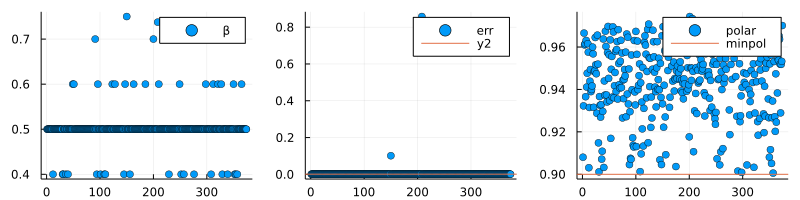

In [17]:
pb = scatter(1:nsamp, betas_seq, label="β")
per = scatter(1:nsamp, errs_seq, label="err")
hline!([pa.tol])
pp = scatter(1:nsamp, polars_seq, label = "polar")
hline!([minpol], label="minpol")
p = plot(pb, per, pp, layout=(1,3), size=(800,200))

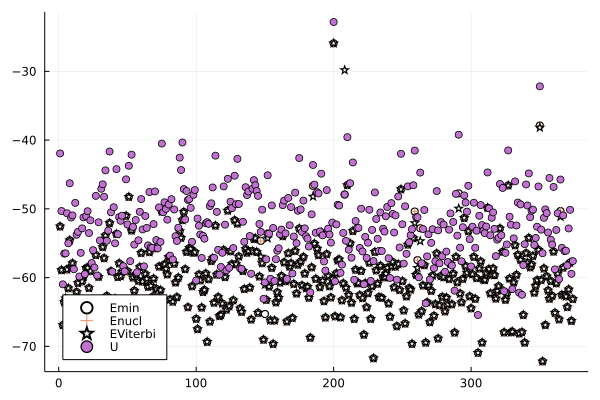

In [18]:
pen = scatter(1:nsamp, ens_seq, label="Emin", m=:circle, c=:white, msw=1.5)
scatter!(1:nsamp, ens_nucleation, label="Enucl", m=:+, msw=1.5)
scatter!(1:nsamp, ens_viterbi, label="EViterbi", m=:star, c=:white, msw=1.5)
scatter!(1:nsamp, U_seq, label="U", legend=:bottomleft)


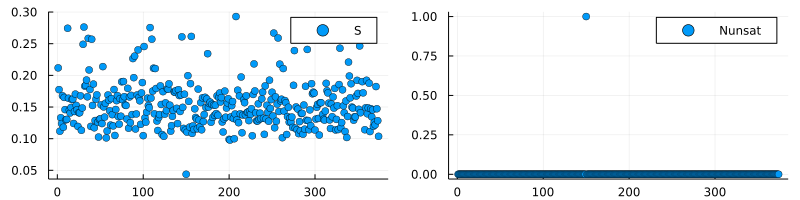

In [19]:
ps = scatter(1:nsamp, S_seq, label="S")
pc = scatter(1:nsamp, check_seq, label="Nunsat")
plot(ps, pc, layout=(1,2), size=(800,200))

In [20]:
n_PmaxgivesSol = sum(check_seq .== 0), findall(check_seq .!= 0)

(373, [150])

In [21]:
findall(ens_nucleation .> ens_seq), findall(ens_viterbi .> ens_seq), findall(ens_viterbi .> ens_nucleation)

([150], [150, 208], [208])

In [22]:
sum(ens_nucleation .< ens_seq), sum(ens_nucleation .== ens_seq), sum(ens_nucleation .> ens_seq)

(0, 373, 1)

In [23]:
sum(ens_viterbi .< ens_seq), sum(ens_viterbi .== ens_seq), sum(ens_viterbi .> ens_seq)

(10, 362, 2)

In [24]:
sum(ens_viterbi .< ens_nucleation), sum(ens_viterbi .== ens_nucleation), sum(ens_viterbi .> ens_nucleation)

(10, 363, 1)

In [25]:
findall(ens_viterbi .> ens_nucleation)

1-element Vector{Int64}:
 208

In [ ]:
#using Plots
#i=1
#idx0 = samples[i]
#N = length(al[idx0][2])
#bel = bels_seq[1:N+2,:,:,i];
#p0 = heatmap(bel[:,1,:], xlabel="i", ylabel="n", title="x=0")
#p1 = heatmap(bel[:,2,:], xlabel="i", ylabel="n", title="x=1")
#p = plot(p0, p1, size=(500,250))

In [ ]:
paramrun = [nsamp, fam, L, M, delta, pa.damp, pa.tol, pa.tolnorm, pa.initcond, pa.lr, iters, minpol, nmax, minbet]

In [ ]:
namefile = "run_GS_"*String(fam)*"_n"*string(nsamp)*"_"*String(pa.lr)*"_maxP.txt"

open(namefile, "a") do io
    writedlm(io, [paramrun])
    writedlm(io, [samps])
end

for (i,idx0) in pairs(samps)
    x0 = [x[1] for x in xnsols_seq[:,i]]
    x1 = [x[2] for x in xnsols_seq[:,i]]
    xc = vcat(x0, x1)
    open(namefile, "a") do io
        writedlm(io, [xc])
    end
end


In [ ]:
namefile = "run_GS_"*String(fam)*"_n"*string(nsamp)*"_"*String(pa.lr)*"_nucleation.txt"

open(namefile, "a") do io
    writedlm(io, [paramrun])
    writedlm(io, [samps])
end

for (i,idx0) in pairs(samps)
    x0 = [x[1] for x in xnsols_nucleation[:,i]]
    x1 = [x[2] for x in xnsols_nucleation[:,i]]
    xc = vcat(x0, x1)
    open(namefile, "a") do io
        writedlm(io, [xc])
    end
end


In [ ]:
namefile = "run_GS_"*String(fam)*"_n"*string(nsamp)*"_"*String(pa.lr)*"_viterbi.txt"

open(namefile, "a") do io
    writedlm(io, [paramrun])
    writedlm(io, [samps])
end

for (i,idx0) in pairs(samps)
    x0 = [x[1] for x in xnsols_viterbi[:,i]]
    x1 = [x[2] for x in xnsols_viterbi[:,i]]
    xc = vcat(x0, x1)
    open(namefile, "a") do io
        writedlm(io, [xc])
    end
end


In [ ]:
open("inds.txt", "a") do io
    writedlm(io, [samps])
end

# -------------- $\epsilon$ increasing --------------

In [ ]:
function extract_data(namefile::String)
    data = readdlm(namefile);
    param = data[1,:]
    nsamp =param[1]

    inds = data[2,1:nsamp];
    res = data[3:end,:];

    xnsols = fill((0,0), L, nsamp)
    for ns in 1:nsamp
        for i=1:L
            x = res[ns,i]
            n = res[ns,L+i]
            xnsols[i,ns] = (x,n)
        end
    end

    return param, inds, xnsols
end


In [10]:
#build paramalgo
damp=T(0.5)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:sequential 
initcond=:random 
lr=:sce  
beta=T(0.0)
verbose=false
xnsol = fill((0, 0), L);
epscoupling=(false, T(0.0), xnsol)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

ParamAlgo{Float32}
-------------
damp=0.5
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=sequential
initcond=random
lr=sce
beta=0.0
verbose=false
epscoupling=false
-------------

In [11]:
epsilons = [-0.0, -0.2, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0, -1.2, -1.3, -1.5]

12-element Vector{Float64}:
 -0.0
 -0.2
 -0.4
 -0.5
 -0.6
 -0.7
 -0.8
 -0.9
 -1.0
 -1.2
 -1.3
 -1.5

In [12]:
length(epsilons)

12

In [13]:
nsamp=100
samps = rand(1:M, nsamp);

In [14]:
betas_seq_eps = zeros(length(epsilons), nsamp)
errs_seq_eps = zeros(length(epsilons), nsamp)
polars_seq_eps = zeros(length(epsilons), nsamp)
ens_seq_eps = zeros(length(epsilons), nsamp)
U_seq_eps = zeros(length(epsilons), nsamp)
S_seq_eps = zeros(length(epsilons), nsamp)
check_seq_eps = zeros(length(epsilons), nsamp)

xnsols_seq_eps = fill((0,0), L, length(epsilons), nsamp);
#bels_seq_eps = ones(Nmax+2,2,L, length(epsilons), nsamp);

In [15]:
#iters = 1000
#minpol = 0.90
#nmax = 30
#minbet = 0.02

iters = 1000
betarange = 0.0:0.05:0.4
minpol = 2.0


2.0

In [ ]:
for (i,idx0) in pairs(samps)

    #build seq, pm
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
    xn = fill((0, 0), L);
    for j in eachindex(epsilons)
        ϵ = epsilons[j]
        @show i, idx0, N, ϵ
        pa.epscoupling = (true, T(ϵ), xn)

        #build BP fields
        bpm = BPMessages(seq, pm, pa)
        bpb = BPBeliefs(N, L)
        lrf = LongRangeFields(N, L)
        af = AllFields(bpm, bpb, lrf)
        
        #find GS
        pa.beta = 0.0
        #@time beta, err, polar, energy, check, U, S, xnsol, bel = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet)
        @time beta, err, polar, energy, check, U, S, xnsol, bel = BpAlignGpu.findGS_betarange(af, pm, pa, seq; iters=iters, betarange = betarange, minpol = minpol)
        
        #decimation using Viterbi
        xnsol, p_vit = BpAlignGpu.viterbi_decoding(af, pm)
        if j == 1
            xn = xnsol
        end
        seqsol = BpAlignGpu.convert_soltosequence!(xnsol, seq.strseq, N, L)
        energy = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
        c = BpAlignGpu.check_sr!(xnsol, L, N)
        if sum(c) > 0
            println("problem during viterbi: new check=", sum(c))
            exit(0)
        end
 
        betas_seq_eps[j,i] = beta
        errs_seq_eps[j,i] = err
        polars_seq_eps[j,i] = polar
        ens_seq_eps[j,i] = energy
        U_seq_eps[j,i] = U
        S_seq_eps[j,i] = S
        check_seq_eps[j,i] = check

        #bels_seq_eps[1:N+2, :, :, j, i] = bel
        xnsols_seq_eps[:,j,i] = xnsol
        @show i, idx0, ϵ, energy, U, err
        println("\n")
    end
    println("\n")
end


(i, idx0, N, ϵ) = (1, 11200, 39, -0.0)
beta = 0.0
converged: err=0.0008814633, tol=0.001, nbiter=117
(polar, energy, err) = (0.09229281f0, 32.349045f0, 0.0008814633f0)
beta = 0.05
converged: err=0.0009022951, tol=0.001, nbiter=12
(polar, energy, err) = (0.10317679f0, 30.859781f0, 0.0009022951f0)
beta = 0.1
converged: err=0.0008434653, tol=0.001, nbiter=12
(polar, energy, err) = (0.11657635f0, 29.961235f0, 0.0008434653f0)
beta = 0.15
converged: err=0.000731647, tol=0.001, nbiter=12
(polar, energy, err) = (0.1330736f0, 23.67285f0, 0.000731647f0)
beta = 0.2
converged: err=0.00094535947, tol=0.001, nbiter=12
(polar, energy, err) = (0.15215588f0, 23.486721f0, 0.00094535947f0)
beta = 0.25
converged: err=0.0009901226, tol=0.001, nbiter=67
(polar, energy, err) = (0.15892223f0, -22.304386f0, 0.0009901226f0)
beta = 0.3
converged: err=0.00096678734, tol=0.001, nbiter=54
(polar, energy, err) = (0.24047118f0, -39.471165f0, 0.00096678734f0)
beta = 0.35
converged: err=0.0009778142, tol=0.001, nbiter=

converged: err=0.000944376, tol=0.001, nbiter=116
(polar, energy, err) = (0.09224372f0, 32.349045f0, 0.000944376f0)
beta = 0.05
converged: err=0.000993222, tol=0.001, nbiter=12
(polar, energy, err) = (0.103264384f0, 30.591389f0, 0.000993222f0)
beta = 0.1
converged: err=0.0009933114, tol=0.001, nbiter=12
(polar, energy, err) = (0.11652402f0, 36.8234f0, 0.0009933114f0)
beta = 0.15
converged: err=0.00096678734, tol=0.001, nbiter=12
(polar, energy, err) = (0.13215922f0, 30.636402f0, 0.00096678734f0)
beta = 0.2
converged: err=0.0008049607, tol=0.001, nbiter=12
(polar, energy, err) = (0.14872138f0, 35.291534f0, 0.0008049607f0)
beta = 0.25
converged: err=0.0009827018, tol=0.001, nbiter=71
(polar, energy, err) = (0.13417903f0, 21.707697f0, 0.0009827018f0)
beta = 0.3
converged: err=0.0009891987, tol=0.001, nbiter=10
(polar, energy, err) = (0.14681695f0, 17.792871f0, 0.0009891987f0)
beta = 0.35
converged: err=0.00093058497, tol=0.001, nbiter=13
(polar, energy, err) = (0.16446327f0, 23.82335f0, 0

In [17]:
pa.tol, pa.damp

(0.001f0, 0.5f0)

In [18]:
mask_errs = (errs_seq_eps .<=0.001)
nb_converged = sum(mask_errs, dims=2)

12×1 Matrix{Int64}:
 100
 100
 100
 100
 100
 100
 100
 100
 100
 100
 100
 100

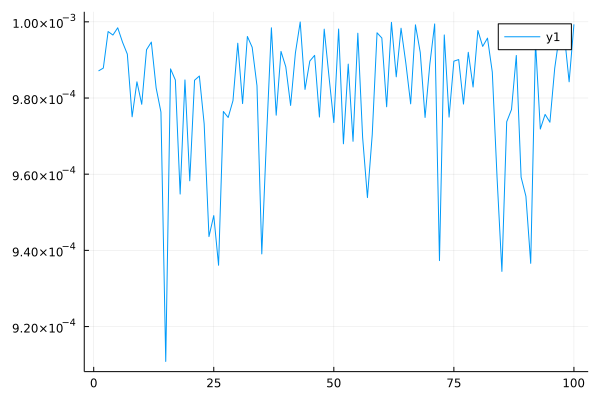

In [19]:
plot(errs_seq_eps[5,:])

In [20]:
findall(errs_seq_eps[1,:] .>0.001)

Int64[]

In [21]:
mask = (check_seq_eps .== 0.0)
nbsol_mean = [mean(mask[j,:]) for j in eachindex(epsilons)]
nbsol_std = [std(mask[j,:]) for j in eachindex(epsilons)]./sqrt(nsamp);
nbsol_mean

12-element Vector{Float64}:
 0.96
 0.87
 0.65
 0.52
 0.26
 0.13
 0.02
 0.08
 0.1
 0.23
 0.18
 0.23

In [23]:
mΔEs = []
vΔEs = []
mΔUs = []
vΔUs = []
mΔdist = []
vΔdist = []
for j in eachindex(epsilons)
    ΔE = []
    ΔU = []
    Δi = []
    for i in 1:nsamp
        if mask_errs[j,i]
            dE = (ens_seq_eps[j,i] - ens_seq_eps[1,i])
            append!(ΔE, dE)
            dU = (U_seq_eps[j,i] - U_seq_eps[1,i])
            append!(ΔU, dU)
            di = sum(xnsols_seq_eps[:,j,i] .!= xnsols_seq_eps[:,1,i])/L
            append!(Δi, di)
        end
    end
    append!(mΔEs, mean(ΔE))
    append!(vΔEs, std(ΔE)/sqrt(nb_converged[j]))
    append!(mΔUs, mean(ΔU))
    append!(vΔUs, std(ΔU)/sqrt(nb_converged[j]))
    append!(mΔdist, mean(Δi))
    append!(vΔdist, std(Δi)/sqrt(nb_converged[j]))
end

In [24]:
epsilons

12-element Vector{Float64}:
 -0.0
 -0.2
 -0.4
 -0.5
 -0.6
 -0.7
 -0.8
 -0.9
 -1.0
 -1.2
 -1.3
 -1.5

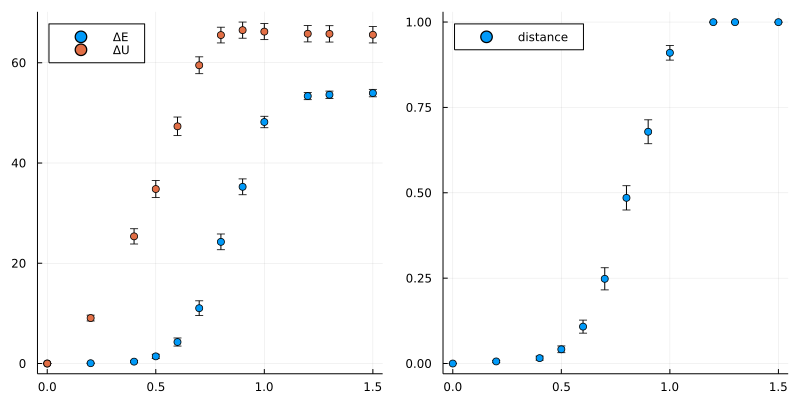

In [25]:
pΔ = scatter(-epsilons, mΔEs, yerr=vΔEs, label="ΔE", legend=:topleft)
scatter!(-epsilons, mΔUs, yerr=vΔUs, label="ΔU")
pdist = scatter(-epsilons, mΔdist, yerr=vΔdist, label="distance", legend=:topleft)
plot(pΔ, pdist, size=(800,400))

In [26]:
mE = []
vE = []
mU = []
vU = []
mS = []
vS = []
for j in eachindex(epsilons)
    EE = []
    UU = []
    SS = []
    for i in 1:nsamp
        if mask_errs[j,i]
            append!(EE, ens_seq_eps[j,i])
            append!(UU, U_seq_eps[j,i])
            append!(SS, S_seq_eps[j,i])
        end
    end
    append!(mE, mean(EE))
    append!(vE, std(EE)/sqrt(nb_converged[j]))
    append!(mU, mean(UU))
    append!(vU, std(UU)/sqrt(nb_converged[j]))
    append!(mS, mean(SS))
    append!(vS, std(SS)/sqrt(nb_converged[j]))
end

In [27]:
[mE, mU, mS]

3-element Vector{Vector{Any}}:
 [-56.54079711914063, -56.4771694946289, -56.16703731536865, -55.11164196014404, -52.24981840133667, -45.50325066119432, -32.270228657871485, -21.2912689884007, -8.362129690870642, -3.1887741266191005, -2.9286977152526377, -2.5935348104685545]
 [-29.50384302139282, -20.43147443771362, -4.138883533477784, 5.30523302078247, 17.813207969665527, 29.993525829315185, 36.01729751586914, 37.001261405944824, 36.70606819152832, 36.27888370513916, 36.25608680725097, 36.07897144317627]
 [0.4393353381752968, 0.5525010195374489, 0.7419778773188591, 0.845648897588253, 0.9767177298665046, 1.0980216354131698, 1.1526718682050705, 1.1581069576740264, 1.1519291162490846, 1.1437536227703093, 1.142090426683426, 1.1375057673454285]

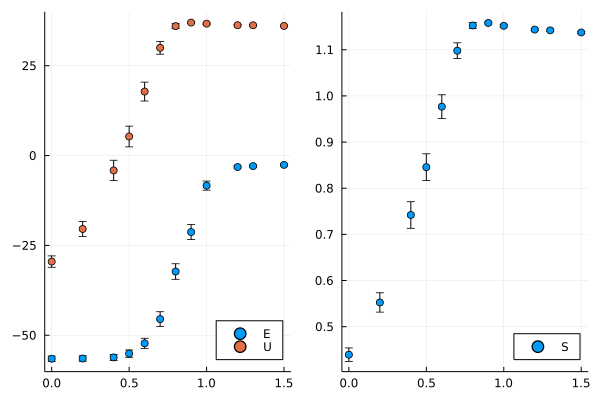

In [28]:
pu = scatter(-epsilons, mE, yerr=vE, label="E", legend=:bottomright)
scatter!(-epsilons, mU, yerr=vU, label="U", legend=:bottomright)
ps = scatter(-epsilons, mS, yerr=vS, label="S", legend=:bottomright)
plot(pu, ps)

In [29]:
μbetas = [mean(betas_seq_eps[j,:]) for j in eachindex(epsilons)]
σbetas = [std(betas_seq_eps[j,:]) for j in eachindex(epsilons)]./sqrt(nsamp)
μerrs = [mean(errs_seq_eps[j,:]) for j in eachindex(epsilons)]
σerrs = [std(errs_seq_eps[j,:]) for j in eachindex(epsilons)]./sqrt(nsamp);

In [30]:
mpolars = []
vpolars = []
for j in eachindex(epsilons)
    pols = []
    for i in 1:nsamp
        if mask_errs[j,i]
            append!(pols, polars_seq_eps[j,i])
        end
    end
    append!(mpolars, mean(pols))
    append!(vpolars, std(pols)/sqrt(nb_converged[j]))
end

In [31]:
μbetas

12-element Vector{Float64}:
 0.4000000059604645
 0.4000000059604645
 0.4000000059604645
 0.4000000059604645
 0.4000000059604645
 0.4000000059604645
 0.4000000059604645
 0.4000000059604645
 0.4000000059604645
 0.4000000059604645
 0.4000000059604645
 0.4000000059604645

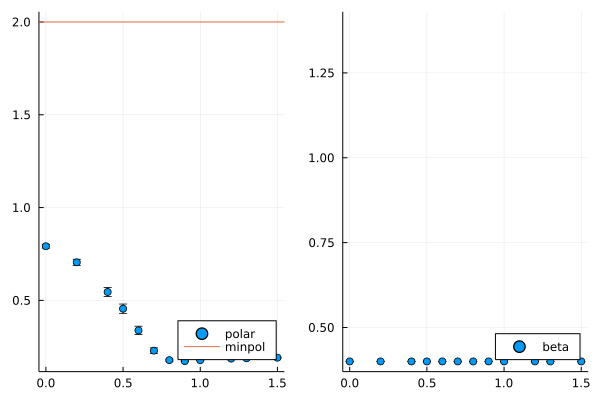

In [32]:
pp = scatter(-epsilons, mpolars, yerr=vpolars, label="polar", legend=:bottomright)
hline!([minpol], label="minpol")
pb = scatter(-epsilons, μbetas, yerr=σbetas, label="beta", legend=:bottomright)
plot(pp, pb)

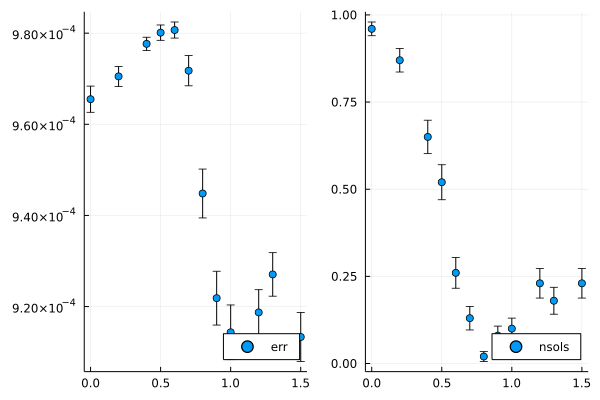

In [33]:
pe = scatter(-epsilons, μerrs, yerr=σerrs, label="err", legend=:bottomright)
pnunsat = scatter(-epsilons, nbsol_mean, yerr=nbsol_std, label="nsols", legend=:bottomright)
plot(pe, pnunsat)

In [34]:
paramrun = [nsamp, fam, L, M, delta, pa.damp, pa.tol, pa.tolnorm, pa.initcond, pa.lr, iters, betarange]
#paramrun = [nsamp, fam, L, M, delta, pa.damp, pa.tol, pa.tolnorm, pa.initcond, pa.lr, iters, minpol, nmax, minbet]

12-element Vector{Any}:
   100
      "PF00397"
    31
 59696
     5
     0.5f0
     0.001f0
     1.0f-10
      :random
      :sce
  1000
      0.0:0.05:0.4

In [35]:
open("inds.txt", "a") do io
    writedlm(io,samps)
end

In [36]:
namefile = "run_epsilon_"*String(fam)*"_"*String(pa.lr)*"_"*string(nsamp)*"_betafixed0p4.txt"
open(namefile, "a") do io
    writedlm(io, [paramrun])
end

open(namefile, "a") do io
    writedlm(io, [epsilons])

    writedlm(io, [mΔEs])
    writedlm(io, [vΔEs])
    writedlm(io, [mΔUs])
    writedlm(io, [vΔUs])
    writedlm(io, [mΔdist])
    writedlm(io, [vΔdist])
    
    writedlm(io, [mE])
    writedlm(io, [vE])
    writedlm(io, [mU])
    writedlm(io, [vU])
    writedlm(io, [mS])
    writedlm(io, [vS])
    
    writedlm(io, [mpolars])
    writedlm(io, [vpolars])
    writedlm(io, [μbetas])
    writedlm(io, [σbetas])
    writedlm(io, [μerrs])
    writedlm(io, [σerrs])

    writedlm(io, [nbsol_mean])
    writedlm(io, [nbsol_std])
end
